## Import

In [26]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import gc
import cv2
import random
import argparse
import numpy as np
import pandas as pd
from glob import glob
import timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import wandb

from utils_.set_path import *
from utils_.set_seed import seed_everything
from utils_.loss import FocalLoss, LabelSmoothingLoss, F1Loss
from utils_.get_class_weight import calc_class_weight
from runner.pytorch_timm import TimmModel
from runner.train_runner import CustomTrainer
from data.dataset import CustomTrainDataset

import matplotlib.pyplot as plt

In [27]:
def main(args, model, model_name, data_dir, device):
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    _, val_ = train_test_split(train_df, test_size=0.2, random_state=args.seed)
    
    val_dataset = CustomTrainDataset(model_name, data_dir, val_['path'].values, args.resize, transforms=False)
    valid_dataloader = DataLoader(val_dataset, batch_size = args.batch_size, shuffle=False, num_workers=8)
    
    model.to(device)
    model = nn.DataParallel(model)
    model.eval()
    
    img_list, label_list, pred_label_list, pred_prob_list = [], [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(valid_dataloader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            logit = model(imgs)

            # pred_list += logit.argmax(1).detach().cpu().numpy().tolist()
            pred_label_list += (logit.max(1))[1].detach().cpu().numpy().tolist()
            pred_prob_list += (logit.max(1))[0].detach().cpu().numpy().tolist()
            # img_list += imgs.detach().cpu().numpy().tolist()
            label_list += labels.detach().cpu().numpy().tolist()
            
        return img_list, pred_label_list, pred_prob_list, label_list, val_dataset

In [28]:
parser = argparse.ArgumentParser()
    
# Data and model checkpoints directories
parser.add_argument('--seed', type=int, default=909)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument("--resize", nargs="+", type=int, default=[512, 384])
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--model', type=str, default='resnet34')
    
args = parser.parse_args(args=[])

In [29]:
seed_everything(args.seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
data_dir = TRAIN_IMG_FOLDER_PATH
model_dir = '/opt/ml/level1_imageclassification-cv-16/geunuk/models'  
project_idx = len(glob(os.path.join(model_dir, '*')))
# project_idx = '13-Aug'
print(f'Project {project_idx} valid inference Start.')

Project 15 valid inference Start.


In [6]:
# Mask
model_name = "Mask"
num_classes = 3
mask_model_weights = torch.load(glob(f'{model_dir}/Project{project_idx}/Mask*')[0])
mask_model = TimmModel(args, num_classes=num_classes, pretrained=True).to(device)
mask_model.load_state_dict(mask_model_weights)

_, mask_preds, mask_labels, val_dataset = main(args, mask_model, model_name, data_dir, device)

KeyboardInterrupt: 

In [6]:
# Gender
model_name = "Gender"
num_classes = 2
args.model = 'efficientnet_b3'
gender_model_weights = torch.load(glob(f'{model_dir}/Project{project_idx}/Gender*')[0])
gender_model = TimmModel(args, num_classes=num_classes, pretrained=True).to(device)
gender_model.load_state_dict(gender_model_weights)

_, gender_preds, gender_labels, val_dataset = main(args, gender_model, model_name, data_dir, device)

tensor([[ 2.7018, -1.2661],
        [ 2.4399, -1.3765],
        [ 3.9129, -2.2997],
        [ 3.2691, -2.0439],
        [ 4.0330, -2.5353],
        [ 2.8444, -0.6594],
        [ 4.0388, -2.9959],
        [-3.5127,  4.2987],
        [-3.8134,  4.3421],
        [-3.9688,  4.5456],
        [-3.4757,  4.0425],
        [-3.5283,  4.1103],
        [-4.7546,  5.1185],
        [-3.3868,  4.4943],
        [-3.0966,  3.8545],
        [-2.7646,  3.4682],
        [-3.6123,  4.0372],
        [-1.9476,  2.3732],
        [-5.0752,  5.9494],
        [-5.1782,  5.5936],
        [-2.4751,  2.9072],
        [-1.5740,  2.8741],
        [-2.3336,  2.9871],
        [ 0.0922,  1.5020],
        [-0.0677,  0.8894],
        [-3.6961,  4.8221],
        [-0.3524,  1.7918],
        [-0.1510,  1.5010],
        [-1.4598,  2.3342],
        [-2.4418,  3.2761],
        [-2.0049,  2.6707],
        [-2.1651,  2.9877]], device='cuda:0')



In [32]:
# Age
model_name = "Age"
num_classes = 2
args.model = 'resnet34'

age_model_weights = torch.load(glob(f'{model_dir}/Project{project_idx}/Age0*')[0])
age_model0 = TimmModel(args, num_classes=num_classes, pretrained=True).to(device)
age_model0.load_state_dict(age_model_weights)

_, age_preds_labels0, age_preds_prob0, age_labels0, val_dataset = main(args, age_model0, model_name, data_dir, device)

age_model_weights = torch.load(glob(f'{model_dir}/Project{project_idx}/Age1*')[0])
age_model1 = TimmModel(args, num_classes=num_classes, pretrained=True).to(device)
age_model1.load_state_dict(age_model_weights)

_, age_preds_labels1, age_preds_prob1, age_labels1, _ = main(args, age_model1, model_name, data_dir, device)

args.model = 'efficientnet_b3'
age_model_weights = torch.load(glob(f'{model_dir}/Project{project_idx}/Age2*')[0])
age_model2 = TimmModel(args, num_classes=num_classes, pretrained=True).to(device)
age_model2.load_state_dict(age_model_weights)

_, age_preds_labels2, age_preds_prob2, age_labels2, _ = main(args, age_model2, model_name, data_dir, device)

In [45]:
c1 = torch.zeros(1, 512, 384) + 0.229
c2 = torch.zeros(1, 512, 384) + 0.224
c3 = torch.zeros(1, 512, 384) + 0.225
std_cn = torch.cat((c1, c2, c3), dim=0)

c1 = torch.zeros(1, 512, 384) + 0.485
c2 = torch.zeros(1, 512, 384) + 0.456
c3 = torch.zeros(1, 512, 384) + 0.406
std_mean = torch.cat((c1, c2, c3), dim=0)

In [46]:
# fig, axes = plt.subplots(5, 4, sharex=True, sharey=True, figsize=(30, 90))

# i = 0
# for idx, (a, b, c) in enumerate(zip(age_preds0, age_preds1, age_preds2)):
#     if a==0 and b==0 and c==0:
#         print(idx, a,b,c, val_dataset[idx][0].shape)        
#         axes[i%5][i//5].imshow((val_dataset[idx][0] * std_cn + std_mean).permute(1, 2, 0).flip(2))
#         i += 1
# plt.tight_layout()

0.7062866687774658 0.4580230414867401 0.41330358386039734
0.5164044499397278 0.17500999569892883 0.44821515679359436
0.4395737051963806 0.4149439334869385 0.3122458755970001
0.7702609896659851 0.4342082440853119 1.0439090728759766
0.44022244215011597 0.4076750874519348 0.5161378979682922
0.4495846629142761 0.17853879928588867 0.4721374213695526
1.315186858177185 0.7098639011383057 0.7832812666893005
1.219397783279419 0.2574343979358673 0.4025735855102539
0.8289596438407898 0.560494065284729 0.42544248700141907
0.9130687117576599 0.5620944499969482 0.44624438881874084


In [33]:
"""
Mask               Gender          Age
- mask      : 0    - male   : 0    - 30 미만         : 0 
- incorrect : 1    - female : 1    - 30 이상 60 미만 : 1
- normal    : 2                    - 60 이상         : 2
"""
label_dict = {(0, 0, 0): 0, (0, 0, 1): 1, (0, 0, 2): 2, (0, 1, 0): 3, (0, 1, 1): 4, 
              (0, 1, 2): 5, (1, 0, 0): 6, (1, 0, 1): 7, (1, 0, 2): 8, (1, 1, 0): 9, 
              (1, 1, 1): 10, (1, 1, 2): 11, (2, 0, 0): 12, (2, 0, 1): 13, (2, 0, 2): 14, 
              (2, 1, 0): 15, (2, 1, 1): 16, (2, 1, 2): 17}

# preds, labels = [], []
# for (mask_pred, gender_pred, age_pred), (mask_label, gender_label, age_label) in zip(zip(mask_preds, gender_preds, age_preds), zip(mask_labels, gender_labels, age_labels)):
#     pred = (mask_pred, gender_pred, age_pred)
#     preds.append(label_dict[pred])
#     label = (mask_label, gender_label, age_label)
#     labels.append(label_dict[label])

# print(f1_score(labels, preds, average='macro'))

error_index = []
imgs, preds, labels = [], [], []
for idx, ((age_pred_label0, age_pred_prob0, age_label), (age_pred_label1, age_pred_prob1, _), (age_pred_label2, age_pred_prob2, _)) in enumerate(zip(zip(age_preds_labels0, age_preds_prob0, age_labels0), zip(age_preds_labels1, age_preds_prob1, age_labels1), zip(age_preds_labels2, age_preds_prob2, age_labels2))):
    if age_pred_label0 == 0 and age_pred_label1 == 1 and age_pred_label2 == 1:
        age_pred = 0
    elif age_pred_label0 == 1 and age_pred_label1 == 0 and age_pred_label2 == 1:
        age_pred = 1
    elif age_pred_label0 == 1 and age_pred_label1 == 1 and age_pred_label2 == 0:
        age_pred = 2
    elif age_pred_label0 == 0 and age_pred_label1 == 0 and age_pred_label2 == 1: # 001
        if age_pred_prob0 > age_pred_prob1: age_pred = 0
        else: age_pred = 1
    elif age_pred_label0 == 0 and age_pred_label1 == 1 and age_pred_label2 == 0: # 010
        if age_pred_prob0 > age_pred_prob2: age_pred = 0
        else: age_pred = 2
    elif age_pred_label0 == 1 and age_pred_label1 == 0 and age_pred_label2 == 0: # 100
        if age_pred_prob1 > age_pred_prob2: age_pred = 1
        else: age_pred = 2
    elif age_pred_label0 == 0 and age_pred_label1 == 0 and age_pred_label2 == 0: # 000
        age_pred = np.argmax(np.array([age_pred_prob0, age_pred_prob1, age_pred_prob2]))
    elif age_pred_label0 == 1 and age_pred_label1 == 1 and age_pred_label2 == 1: # 111
        age_pred = np.argmin(np.array([age_pred_prob0, age_pred_prob1, age_pred_prob2]))
        
    if age_pred != age_label:
        error_index.append(idx)
        preds.append(age_pred)
        labels.append(age_label)
        
print(len(error_index))

625


In [37]:
misprediction_count = {
    (0, 1) : 0,
    (0, 2) : 0,
    (1, 0) : 0,
    (1, 2) : 0,
    (2, 0) : 0,
    (2, 1) : 0
}
misprediction_tostring = {
    (0, 1) : "pred <30, label 30to60",
    (0, 2) : "pred <30, label >60",
    (1, 0) : "pred 30to60, label <30",
    (1, 2) : "pred 30to60, label >60",
    (2, 0) : "pred >60, label <30",
    (2, 1) : "pred >60, label 30to60",
}

In [39]:
for pred, label in zip(preds, labels):
    misprediction_count[(pred, label)] += 1
    
for key, value in misprediction_count.items():
    print(f'{misprediction_tostring[key]}: {value}')
    
misprediction_count

KeyError: (8, 6)

In [11]:
test = np.array(list(zip(preds, labels)))
indices = np.where((test[:, 0] == 0) & (test[:, 1] == 1))
indices = indices[0]

In [14]:
class_dict = {0: "< 30", 1:"30 to 60", 2:"> 60"}

In [15]:
class_counts_train = {i:0 for i in range(3)}
class_counts_val = {i:0 for i in range(3)}

for img, target in val_dataset:
    class_counts_val[target] += 1
    
class_counts_val


{0: 1687, 1: 1750, 2: 343}

In [27]:
print(torch.Tensor(img[0]))

torch.Size([256, 192])


In [41]:
age_labels

[[2, 0, 1],
 [2, 0, 1],
 [2, 0, 1],
 [2, 0, 1],
 [0, 2, 1],
 [2, 0, 1],
 [2, 0, 1],
 [2, 1, 0],
 [2, 1, 0],
 [2, 1, 0],
 [2, 1, 0],
 [2, 1, 0],
 [2, 1, 0],
 [2, 1, 0],
 [6, 8, 7],
 [9, 8, 7],
 [9, 8, 7],
 [6, 8, 7],
 [9, 8, 7],
 [9, 8, 7],
 [4, 8, 7],
 [6, 3, 4],
 [5, 6, 4],
 [5, 3, 4],
 [6, 3, 4],
 [2, 3, 4],
 [3, 6, 4],
 [6, 3, 4],
 [2, 0, 1],
 [2, 0, 1],
 [2, 0, 1],
 [2, 0, 1]]

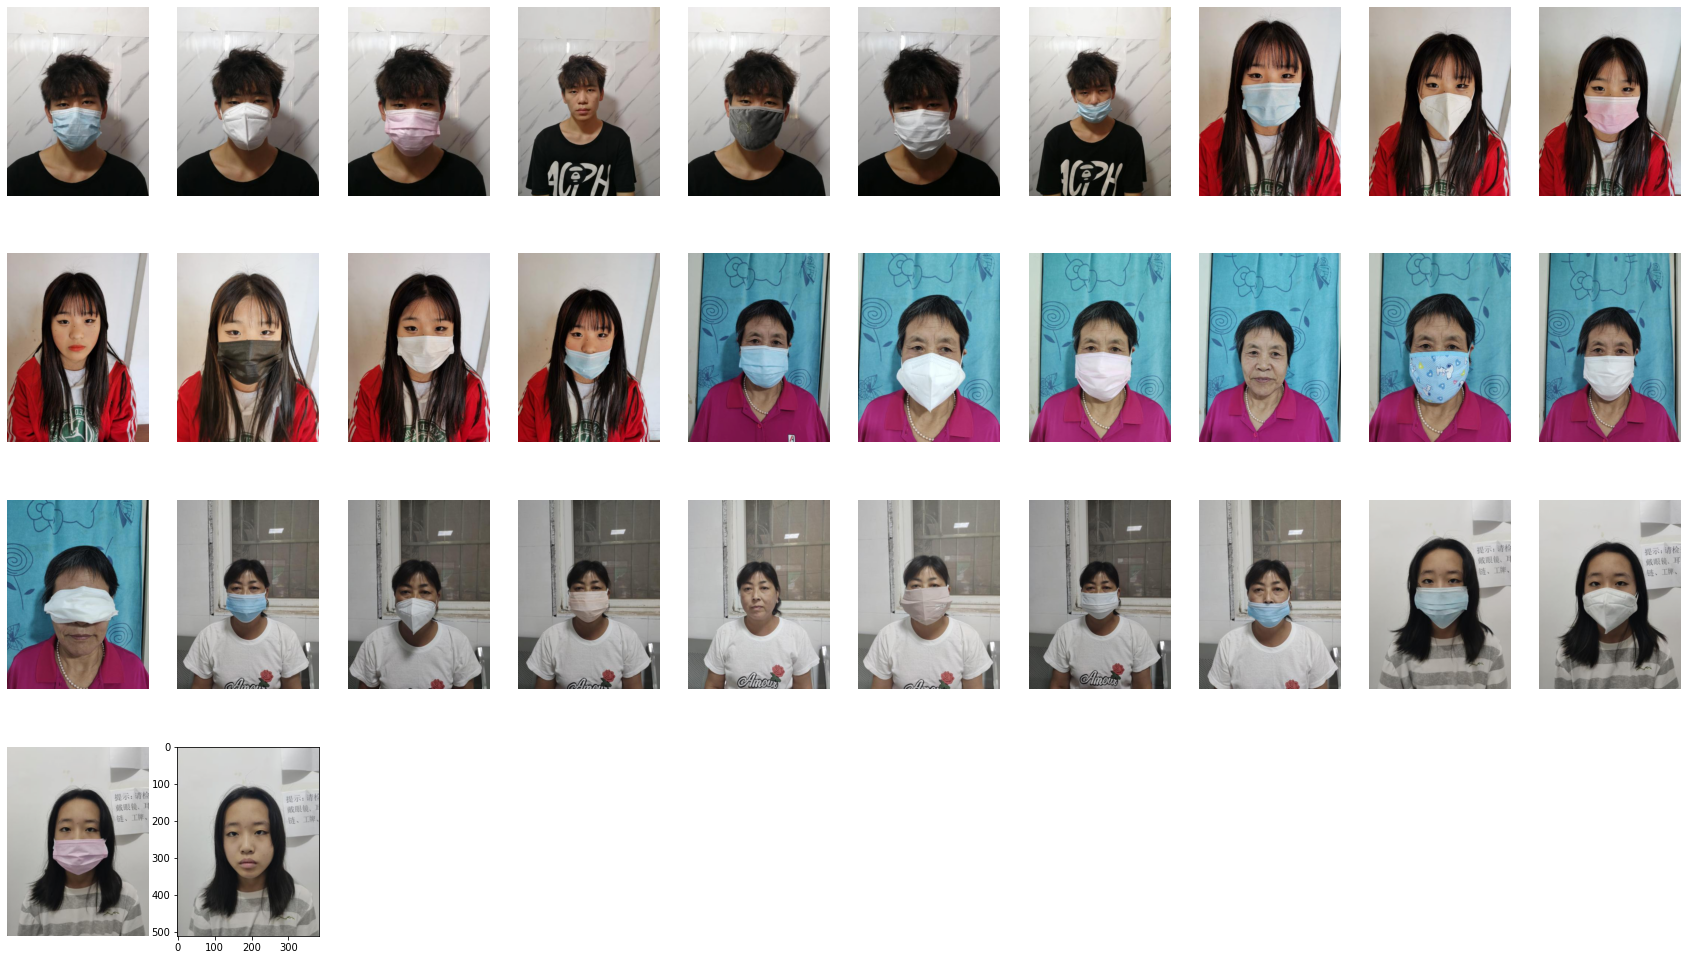

In [35]:
plt.figure(figsize=(30, 90))
for idx, (img, pred, label) in enumerate(zip(age_imgs, age_preds, age_labels)):
    if pred != label:
        plt.axis("off")
        plt.subplot(20, 10, idx+1)
        # plt.title(f"pred:{class_dict[pred]}, label:{class_dict[label]}", color="white")
        plt.imshow((torch.Tensor(img) * std_cn + std_mean).permute(1, 2, 0).flip(2))